In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import vr2p
import gcsfs, pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from vr2p import styles
import yaml
from multiday_suite2p.transform import cluster_cell_masks
import math

# Main Parameters.

In [2]:
animals = ['A4','A5','A7','B2','B3','B4','B5','C1','D1','F1', 'F5']
bin_size = 10
# cluster Settings
cluster_settings = """
criterion: "distance" # criterion used for clustering
threshold: 0.75 # Threshold used for clustering algorithm
min_sessions_perc: 0 #Exclude masks not present for this percentage of sessions (0-100).
min_perc: 50 #Create template based on pixels detected in X% of sesions.
step_sizes: [200,200] # clustering happens in these sizes blocks across the plane (for memory reasons)
bin_size: 50 # Look for masks around center+bin-size to avoid edge cases
min_distance: 20 # only masks with centers within this pixel radius of each other are considered for clustering.
min_size_non_overlap: 25 # minimum size of template mask in pixels.
  """
cluster_settings = yaml.safe_load(cluster_settings)
cluster_settings['min_sessions_perc'] = 0 # include all.

# Run clustering for all animals with adjusted settings

This dataset is limited to session for set A (equal all animals)

In [ ]:
recalculate = False
if recalculate:
    # Collect data.
    def run_clustering(animal, cluster_settings):
        # get vr2p data
        data = vr2p.ExperimentData(f'/.../Set A/Tyche-{animal}-SetA.zarr')
        im_size = data.images.registered[0]['mean_img'].shape
        # registration data.
        fs = gcsfs.GCSFileSystem(project='sprustonlab-meso')
        with fs.open(f'/.../registration/register-Tyche-{animal}.pkl', 'rb') as handle:
            deforms, trans_images,trans_masks, trans_label_im = pickle.load(handle)
        #  assert that number of sessions align.
        assert len(trans_masks)== len(data.images.registered) ,'Number of sessions in data and stored registration do not match'
        # cluster and create template masks.
        matched_cells, matched_im = cluster_cell_masks(trans_masks, im_size, cluster_settings,verbose=False)
        return {'animal':animal,'num_sessions': len(matched_im), 'matched_cells':matched_cells}
    matched_info = [ run_clustering(animal, cluster_settings) for animal in tqdm(animals) ] 
    # store.
    with open('matched_info.pkl', 'wb') as f:
        pickle.dump(matched_info, f)

In [4]:
if not recalculate:
    with open('matched_info.pkl','rb') as f:  
        matched_info = pickle.load(f)

# Collect information for plot.
first list is animal

second list is cluster

In [ ]:
animal_id = 2
print(f"Animal: {matched_info[animal_id]['animal']}")
matched = matched_info[animal_id]
num_sessions = matched["num_sessions"]
print(f"Number of sessions: {num_sessions}")
mask_info = []
for cluster in matched["matched_cells"]:
    num_sessions_cluster = len(cluster)
    # get pixel indices
    xpix = np.concatenate([cell['xpix'] for cell in cluster])
    ypix = np.concatenate([cell['ypix'] for cell in cluster])
    pix = np.vstack((xpix, ypix)).T
    # get pixels that are present atleast in 50% of the sessions of this cluster
    unique, counts = np.unique(pix, return_counts=True, axis=0)
    pix = unique[counts >= num_sessions_cluster / 2]
    mask_info.append(
        {
            "pixels": pix,
            "perc_sessions": (num_sessions_cluster / num_sessions)*100,
            "observed": num_sessions_cluster,
        }
    )
print(f"Number of clusters: {len(mask_info)}")

# get animal data
data = vr2p.ExperimentData(f"/.../Set A-E/Tyche-{matched['animal']}")
pix_size = np.array([1.333, 2])[::-1]
# get fov size.
fov_size = np.array(data.images.registered[0]['mean_img'].shape)
fov_size_mm = fov_size * (pix_size/1000)
print(f"FOV size: {fov_size}")

Animal: A7
Number of sessions: 9
Number of clusters: 10499
FOV size: [ 823 1386]


# Create map image.

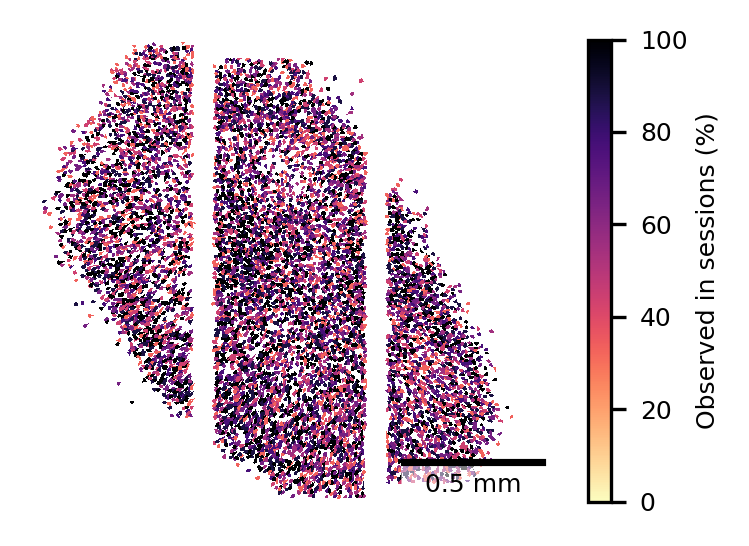

In [6]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.patches import FancyBboxPatch


im_size_inch = [3.35, 2]
# create a mask image.
mask_im = np.zeros(fov_size.astype(int), "uint8")
# fill in the masks.
for mask in mask_info:
    if mask["observed"] < 3:
        continue
    mask_im[mask["pixels"][:, 1], mask["pixels"][:, 0]] = mask["perc_sessions"]
mask_im = np.ma.masked_where(mask_im == 0, mask_im)
# Create a color map based on viridis but set 0 to black.
cmap = plt.cm.magma_r  # plt.cm.viridis
cmap.set_bad(color="white", alpha=1)
# set 0 to bad

# Create image.
# Define the mosaic layout
layout = [
    ['plot', 'None'],
    ['plot', 'cbar']
]

# Create the mosaic plot
fig, ax_dict = plt.subplot_mosaic(layout, figsize=(8, 6))
fig, axs = plt.subplots(1, 1, figsize=im_size_inch, dpi=300)
shown_im = axs.imshow(
    mask_im, cmap=cmap, vmin=0, vmax=100, extent=[0, fov_size_mm[1], 0, fov_size_mm[0]],
    interpolation="nearest"
)
# add a colorbar on the right
cbar = plt.colorbar(shown_im, ax=axs, orientation="vertical" )
cbar.ax.tick_params(labelsize=6) 
cbar.set_label("Observed in sessions (%)", rotation=90, labelpad=2, fontsize=6)
# turn off the axis
axs.axis("off")
# Add a scalebar
scalebar = AnchoredSizeBar(
    axs.transData,
    0.5,  # Length of scalebar in data units
    "0.5 mm",  # Label
    "lower right",  # Location
    pad=0.1,
    color="black",
    frameon=True,
    size_vertical=0.01,
    fontproperties=fm.FontProperties(size=6),
)

axs.add_artist(scalebar)

# Modify the frame properties to set the background color and opacity
frame = scalebar.patch
frame.set_facecolor('white')
frame.set_alpha(0.5)
frame.set_edgecolor('none')

